In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
import numpy as np



In [80]:
# plt.scatter(data[:,0], data[:,1], marker='.')
# plt.show()

In [81]:
class DBScanner:
    def __init__(self, data,dataset_name):
        self.data = data
        self.visited = []
        self.all_clusters = []
        self.dataset_name = dataset_name
        
    def init_param(self, EPS, MINPTS):
        self.EPS, self.MINPTS = EPS, MINPTS
        
    
    def create_dist_matrix(self):
        self.matrix = np.zeros([self.final_data.shape[0], self.final_data.shape[0]])
        
        for i in range(self.final_data.shape[0]):
            for j in range(i+1, self.final_data.shape[0]):
                self.matrix[j, i] = distance.euclidean(self.final_data[i], self.final_data[j])
                self.matrix[i, j] = self.matrix[j, i]
                
        self.matrix = (self.matrix <= self.EPS).astype(int)        
        #print(self.matrix.shape)
        #print(self.matrix)
            
        
    def get_neighbors(self, point):
        result = []
        
        for node_point in self.data:
            dist = distance.euclidean(node_point, point)
            if dist <= self.EPS:
                result.append(node_point)
                
        return result
    
    def expand_cluster(self,cur):
        self.init_clusters[cur]['visited'] = True
        
        members = []
        members.extend(self.init_clusters[cur]['pts'])
        
        crstring = str(cur)
        for member in self.init_clusters[cur]['pts']:
            if member in self.init_clusters:
                if self.init_clusters[member]['visited'] is False:
                    temp, temp_members = self.expand_cluster(member)                    
                    members.extend(temp_members)
                    crstring += temp
        return crstring, members    
    
    def get_result(self):
                
        fig = plt.figure()
        axis_proj = 'rectilinear'
        ax = fig.add_subplot(111, projection = axis_proj)
        
        noise_cluster = []
        
        #noisy_data_elim
        self.final_data = []
        for point in self.data:
            neighbour = self.get_neighbors(point)
            
            # step one, eliminate noises
            if len(neighbour) < self.MINPTS:
                noise_cluster.append(point)
            else:
                self.final_data.append(point)
        
        noise_cluster = np.array(noise_cluster)
        self.final_data = np.array(self.final_data)
        
        #print(noise_cluster[:,0])
        #print(noise_cluster[0].shape)
        ax.scatter(noise_cluster[:,0], noise_cluster[:,1], marker = 'x', label = "noise")
        
        self.create_dist_matrix()
        
        self.init_clusters = {}

        for i in range(self.matrix.shape[0]):
            if self.matrix[i].sum() >= self.MINPTS:
                self.init_clusters[i] = {'visited': False,'pts': np.where(self.matrix[i] == 1)[0].tolist()}
        
        self.clusters = {}
        for each_clus in self.init_clusters:
            if self.init_clusters[each_clus]['visited'] is False:
                each_clus_str, pts = self.expand_cluster(each_clus)
                self.clusters[each_clus_str] = pts
                
        for iter,each_clus_str in enumerate(self.clusters):
            cluster_pts = self.final_data[self.clusters[each_clus_str]]
            ax.scatter(cluster_pts[:, 0], cluster_pts[:, 1], label = "cluster"+str(iter))
            
        print ("Number of clusters found: %d" % len(self.clusters))      
        
        ax.legend(bbox_to_anchor=(1.1,1.05))
        plt.title(r'DBSCAN Clusters for eps='+str(self.EPS)+ ' and minpts = 4', fontsize=18)
        plt.savefig(self.dataset_name+'.png')
        plt.show()        
        
   

(600, 2)
(600,)


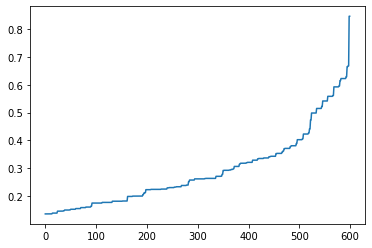

In [82]:
data = np.loadtxt('bisecting.txt')
print(data.shape)

nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(data)
distances, _ = nbrs.kneighbors(data)

fourth_dist = distances[:,-1]
print(fourth_dist.shape)  

sorted_dis = np.sort(fourth_dist)
dummy = np.arange(0, fourth_dist.shape[0])
plt.plot(dummy, sorted_dis)
plt.show()

Number of clusters found: 12


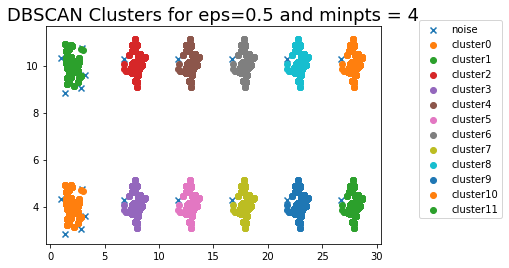

In [83]:
DBScan = DBScanner(data,dataset_name='bisecting')
DBScan.init_param(0.5, 4)
DBScan.get_result()

# KNN


In [77]:
class KNN:
    def __init__(self, data,dataset_name,k):
        self.data = data
        self.dataset_name = dataset_name
        self.k = k
        self.centroids = np.zeros((self.k,2))
        self.cluster_pts = [[] for _ in range(self.k)]
        
    def initialization(self):
        for i in range(self.k):
            val = np.random.choice(self.data.shape[0])
            self.centroids[i] = self.data[val] #np.random.uniform(low=self.data[:, 0].min(), high=self.data[:, 0].max()), np.random.uniform(low=self.data[:, 1].min(), high=self.data[:, 1].max())
    
    def cluster_assignment(self):
        
        cluster_pts = [[] for _ in range(self.k)]
        for each_data in self.data:
            temp = np.zeros(self.k)
            for iter, each_cluster in enumerate(self.centroids):
                temp[iter] = distance.euclidean(each_data, each_cluster)
        
            cur_cluster = np.argmin(temp)
            cluster_pts[cur_cluster].append(each_data)
            
        return cluster_pts
    
    def centroid_move(self):
        
        fig = plt.figure()
        axis_proj = 'rectilinear'
        ax = fig.add_subplot(111, projection = axis_proj)
        
        ax.scatter(self.centroids[:,0], self.centroids[:,1], marker = 'x', label = "centroids")
        
        count = 0
        for iter, each_cluster_cent in enumerate(self.centroids):
            
            if len(self.cluster_pts[iter]) == 0:
                continue
                
            new_centroid = np.mean(self.cluster_pts[iter], 0)
            print("new_centroid",new_centroid)
            
            # no update, exit
            if (new_centroid == each_cluster_cent).sum() == each_cluster_cent.shape[0]:
                count += 1
            else:
                self.centroids[iter] = new_centroid
                         
            temp = np.array(self.cluster_pts[iter])
            ax.scatter(temp[:, 0], temp[:, 1], label = "cluster"+str(iter))
        
        ax.legend(bbox_to_anchor=(1.1,1.05))
        plt.title(r'KNN Clusters for dataset='+self.dataset_name, fontsize=18)
        plt.savefig(self.dataset_name+'.png')
        plt.show()        
        
        return count
    
    def get_result(self):
        #step_1
        self.initialization()
        
        while True:
            #step_2
            self.cluster_pts = self.cluster_assignment()
            #step_3
            exit = self.centroid_move()

            if exit == self.k:
                print("finished")
                break     
        
    
        

(2500, 2)
new_centroid [ 1.51314367 -0.13794841]
new_centroid [0.03629177 0.42487561]


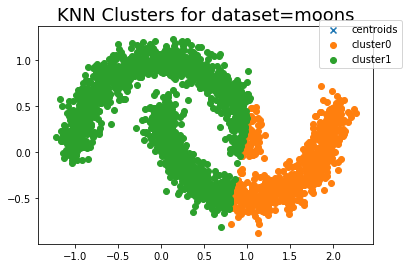

new_centroid [ 1.36422072 -0.13048313]
new_centroid [-0.06864239  0.49696531]


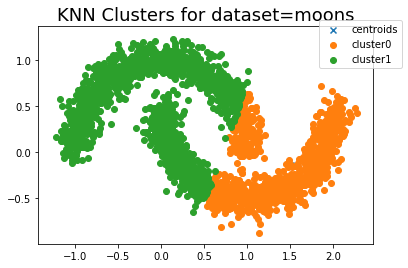

new_centroid [ 1.28777644 -0.11130213]
new_centroid [-0.13235569  0.53622439]


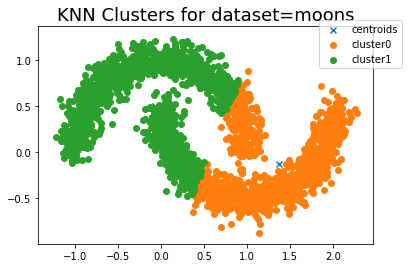

new_centroid [ 1.24682092 -0.09294667]
new_centroid [-0.17213161  0.5546447 ]


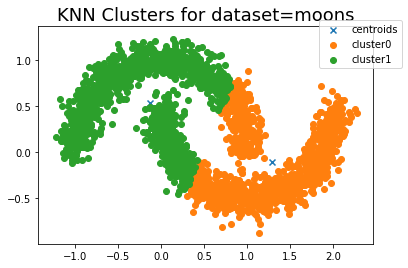

new_centroid [ 1.22681718 -0.08418457]
new_centroid [-0.1918665   0.56399766]


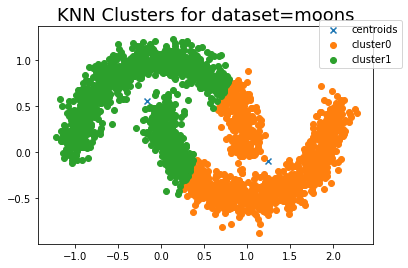

new_centroid [ 1.21734981 -0.07786534]
new_centroid [-0.20280581  0.56706173]


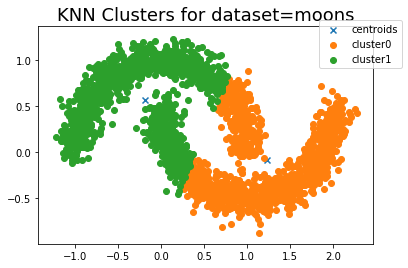

new_centroid [ 1.21416929 -0.07729929]
new_centroid [-0.20531344  0.56905936]


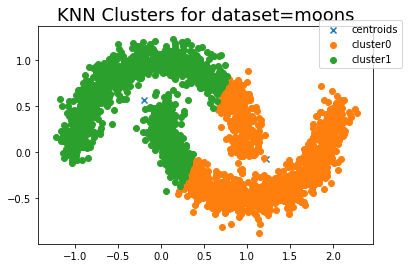

new_centroid [ 1.2130483  -0.07672279]
new_centroid [-0.20646335  0.56951817]


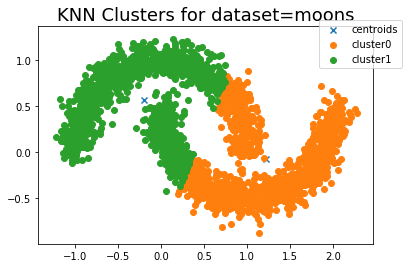

new_centroid [ 1.2130483  -0.07672279]
new_centroid [-0.20646335  0.56951817]


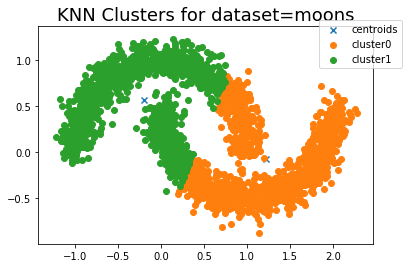

finished


In [78]:
data = np.loadtxt('moons.txt')
print(data.shape)

KNN = KNN(data,dataset_name='moons',k=2)
KNN.get_result()